# Davis, CA Apartment Complexes Analysis Report
## For Students Looking for Housing

This notebook examines apartment complexes in Davis, CA with a focus on factors important to students selecting housing: pricing, location, accessibility, safety, and quality.

### Data Sources
- **48 Apartment Complexes**: Rent prices, square footage, ratings, distances to UC Davis
- **23 Grocery Stores**: Locations, ratings, types
- **286 Bus Stops**: Locations, accessibility information
- **321 Crime Records**: Types, severity, locations, dates
- **Distance Data**: Calculated distances between apartments and all other points of interest

### Analysis Goals
1. Understand pricing distributions and value metrics
2. Analyze proximity to UC Davis and commute times
3. Evaluate accessibility to grocery stores and public transit
4. Assess safety through crime pattern analysis
5. Examine quality through ratings and reviews
6. Create comprehensive rankings to help students make informed decisions


## 1. Data Loading & Initial Exploration


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load all datasets
apartments = pd.read_csv('final_datasets/apartments.csv')
grocery_stores = pd.read_csv('final_datasets/grocery_stores.csv')
bus_stops = pd.read_csv('final_datasets/bus_stops.csv')
crimes = pd.read_csv('final_datasets/crimes.csv')
bus_stop_distances = pd.read_csv('final_datasets/bus_stop_distances.csv')
grocery_store_distances = pd.read_csv('final_datasets/grocery_store_distances.csv')
crime_distances = pd.read_csv('final_datasets/crime_distances.csv')


In [3]:
apartments.head(3)

,id,name,address,lat,lng,place_id,rating,user_ratings_total,types,apartments_url,rent_min,rent_max,sqft_min,sqft_max,rent_per_sqft_avg,ucd_distance_miles,ucd_time_min
0,0,Adobe At Evergreen Apartments,"1500 Shasta Dr, Davis, CA 95616, United States",38.560068,-121.771209,ChIJJZ9VaDYohYARyucU7yZq_tE,4.1,26.0,"['point_of_interest', 'establishment']",https://www.apartments.com/adobe-at-evergreen-...,618.0,1558.0,1024.0,1614.0,0.824867,2.615979,9.133333
1,1,Aero Apartments,"1805 Anderson Rd, Davis, CA 95616, United States",38.559552,-121.759491,ChIJidXngbYphYARi8JqrRY1Rv8,4.5,4.0,"['point_of_interest', 'establishment']",https://www.apartments.com/aero-apartments-dav...,1750.0,2600.0,675.0,925.0,2.718750,1.558403,6.550000
2,2,Aggie Square Apartments,"644 Alvarado Ave, Davis, CA 95616, United States",38.561417,-121.756580,ChIJmVyds7cphYAROS8Y7UPbX_w,4.9,31.0,"['point_of_interest', 'establishment']",https://www.apartments.com/aggie-square-apartm...,1770.0,2995.0,764.0,1093.0,2.565967,1.846720,7.283333


In [4]:
grocery_stores.head(3)

,id,name,address,lat,lng,place_id,rating,user_ratings_total,types
0,0,Davis Food Co-op,"620 G St, Davis, CA 95616, United States",38.549321,-121.740026,ChIJIxr01p8phYAR8FDlyrQ3DQE,4.6,1056.0,"['grocery_or_supermarket', 'supermarket', 'poi..."
1,1,Fast & Easy Mart,"140 B St, Davis, CA 95616, United States",38.542620,-121.743971,ChIJ6_TBmQwphYARFqWiXnJb12A,2.5,29.0,"['convenience_store', 'grocery_or_supermarket'..."
2,2,Grocery Outlet,"1800 E 8th St Suite B, Davis, CA 95616, United...",38.552623,-121.729764,ChIJvzf9uoIphYARCYMgDCAXErg,4.4,706.0,"['grocery_or_supermarket', 'supermarket', 'poi..."


In [5]:
bus_stops.head(3)

,Stop ID (3 Digit),Stop ID (Full),Stop Location,Latitude,Longitude,Known Accessibility Issue?
0,124,22124,14th St & B St (EB),38.555899,-121.747879,NaN
1,123,22123,14th St & B St (WB),38.556086,-121.748155,NaN
2,125,22125,14th St & Davis HS (WB),38.555965,-121.750585,NaN


In [6]:
crimes.head(3)

,Report Date,Case Number,Date Occurred,Time Occurred,Location,Report Classification,Disposition,Severity,lat,lng
0,12/2/2025,C25-1588,12/1/25-12/2/25,15:30-10:11,598 Tercero Hall Dr,Vandalism: Hate Crime Anti Racial,Suspended. No leads,7.0,38.536733,-121.756509
1,12/2/2025,C25-1589,12/2/2025,11:32,355 Howard Way,Vehicle Collision,Closed. No further action,1.0,38.543910,-121.750169
2,12/2/2025,C25-1590,12/2/2025,14:24,200 Atrium Way,Bicycle Collision,Closed. No further action,1.0,38.545741,-121.761028


## 2. Data Cleaning & Derived Variables


In [7]:
# Create derived variables for apartments
apartments['rent_range'] = apartments['rent_max'] - apartments['rent_min']
apartments['sqft_range'] = apartments['sqft_max'] - apartments['sqft_min']
apartments['avg_rent'] = (apartments['rent_min'] + apartments['rent_max']) / 2

# Create price category based on rent_min
def categorize_price(rent_min):
    if pd.isna(rent_min):
        return 'Unknown'
    elif rent_min < 1500:
        return 'Budget'
    elif rent_min < 2500:
        return 'Mid-range'
    else:
        return 'Premium'

apartments['price_category'] = apartments['rent_min'].apply(categorize_price)

apartments[['name', 'rent_min', 'rent_max', 'avg_rent', 'price_category']].head(10)

,name,rent_min,rent_max,avg_rent,price_category
0,Adobe At Evergreen Apartments,618.0,1558.0,1088.0,Budget
1,Aero Apartments,1750.0,2600.0,2175.0,Mid-range
2,Aggie Square Apartments,1770.0,2995.0,2382.5,Mid-range
3,Almondwood Apartments,1770.0,2425.0,2097.5,Mid-range
4,Alvarado Parkside Apartments,2195.0,2495.0,2345.0,Mid-range
5,Anderson Place Apartments,1240.0,2490.0,1865.0,Budget
6,Arlington Farm,650.0,2300.0,1475.0,Budget
7,Avalon Apartments,3239.0,3999.0,3619.0,Premium
8,Axis at Davis,820.0,1489.0,1154.5,Budget
9,Cascade Apartments,1795.0,2195.0,1995.0,Mid-range


### Crime Severity Counts

In [8]:
# Create crime severity categories
def categorize_severity(severity):
    if pd.isna(severity):
        return 'Unknown'
    elif severity <= 3:
        return 'Low'
    elif severity <= 6:
        return 'Medium'
    else:
        return 'High'

crimes['severity_category'] = crimes['Severity'].apply(categorize_severity)

# Extract main crime type from Report Classification
crimes['crime_type'] = crimes['Report Classification'].str.split(':').str[0].str.strip()
crimes['crime_type'] = crimes['crime_type'].str.split(' ').str[0].str.strip()

crimes['severity_category'].value_counts()

severity_category
Low        177
Medium     128
High        14
Unknown      2
Name: count, dtype: int64

### Top 10 Crime Types

In [9]:
crimes['crime_type'].value_counts().head(10)

crime_type
MSR            72
Stolen         65
Theft          39
Bicycle        34
Vehicle        18
MSR-Alcohol    11
Vandalism      10
Fraud           7
Simple          4
Burglary        4
Name: count, dtype: int64

### Bus Stop Distances

In [10]:
print(f"Min: {bus_stop_distances['distance_miles'].min():.2f} miles, "
      f"Max: {bus_stop_distances['distance_miles'].max():.2f} miles, "
      f"Mean: {bus_stop_distances['distance_miles'].mean():.2f} miles")

Min: 0.01 miles, Max: 6.79 miles, Mean: 2.31 miles


### Grocery Store Distances

In [11]:
print(f"Min: {grocery_store_distances['distance_miles'].min():.2f} miles, "
      f"Max: {grocery_store_distances['distance_miles'].max():.2f} miles, "
      f"Mean: {grocery_store_distances['distance_miles'].mean():.2f} miles")

Min: 0.08 miles, Max: 22.87 miles, Mean: 3.77 miles


### Crime Distances

In [12]:
print(f"Min: {crime_distances['distance_miles'].min():.2f} miles, "
      f"Max: {crime_distances['distance_miles'].max():.2f} miles, "
      f"Mean: {crime_distances['distance_miles'].mean():.2f} miles")

Min: 0.02 miles, Max: 5.64 miles, Mean: 1.78 miles


## 3. Pricing Analysis

This section examines the distribution of rent prices, square footage, and value metrics across all apartment complexes.


In [13]:
pricing_cols = ['rent_min', 'rent_max', 'avg_rent', 'rent_per_sqft_avg', 'sqft_min', 'sqft_max']
pricing_stats = apartments[pricing_cols].describe()
pricing_stats

,rent_min,rent_max,avg_rent,rent_per_sqft_avg,sqft_min,sqft_max
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,1788.812500,2734.666667,2261.739583,2.410418,796.104167,1154.666667
std,643.749081,717.376821,534.724994,0.592447,247.016774,325.284513
min,480.000000,1489.000000,1088.000000,0.824867,506.000000,750.000000
25%,1616.750000,2298.750000,1948.750000,2.178042,608.250000,907.750000
50%,1846.500000,2515.000000,2152.500000,2.558835,693.500000,996.000000
75%,2193.500000,3217.500000,2568.125000,2.664767,950.000000,1341.500000
max,3239.000000,4500.000000,3722.500000,3.766859,1445.000000,1860.000000


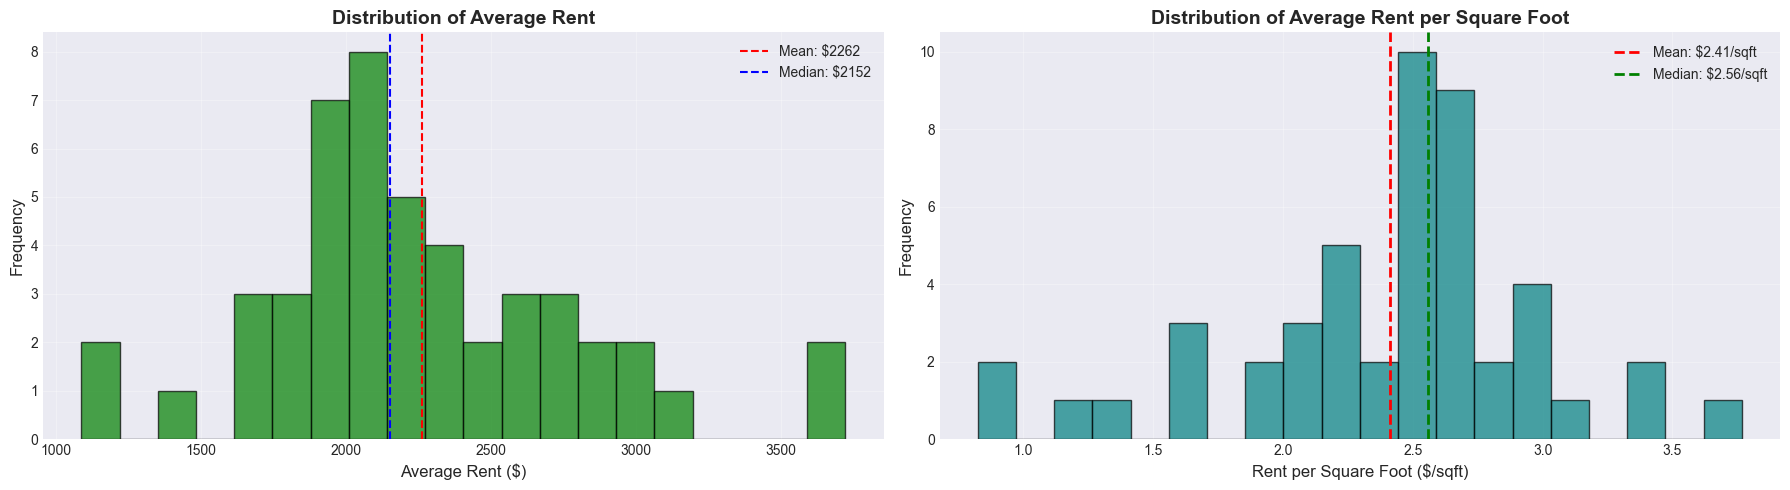

In [ ]:
# Rent distribution visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Histogram of avg_rent
axes[0].hist(apartments['avg_rent'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(apartments['avg_rent'].mean(), color='red', linestyle='--', label=f'Mean: ${apartments["avg_rent"].mean():.0f}')
axes[0].axvline(apartments['avg_rent'].median(), color='blue', linestyle='--', label=f'Median: ${apartments["avg_rent"].median():.0f}')
axes[0].set_xlabel('Average Rent ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Average Rent', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of rent_per_sqft_avg
axes[1].hist(apartments['rent_per_sqft_avg'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='teal')
axes[1].axvline(apartments['rent_per_sqft_avg'].mean(), color='red', linestyle='--', 
           label=f'Mean: ${apartments["rent_per_sqft_avg"].mean():.2f}/sqft', linewidth=2)
axes[1].axvline(apartments['rent_per_sqft_avg'].median(), color='green', linestyle='--', 
           label=f'Median: ${apartments["rent_per_sqft_avg"].median():.2f}/sqft', linewidth=2)
axes[1].set_xlabel('Rent per Square Foot ($/sqft)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Average Rent per Square Foot', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

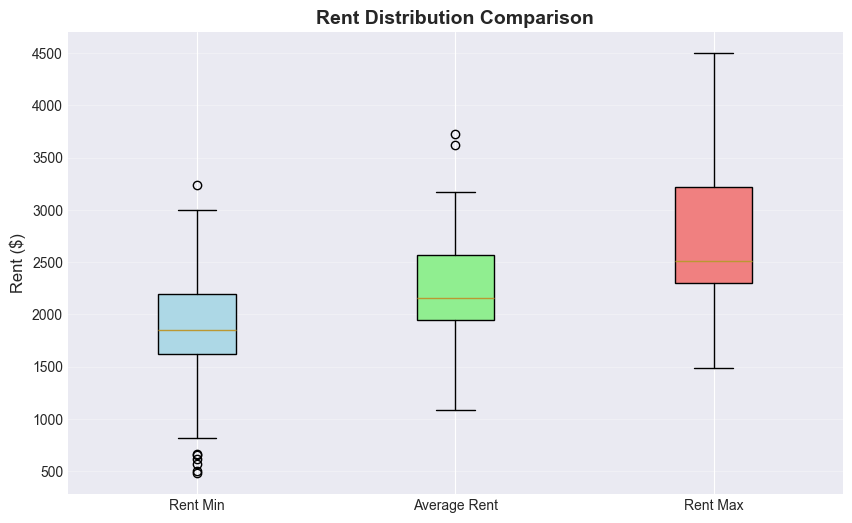

In [15]:
# Box plot comparing rent_min, avg_rent, and rent_max
fig, ax = plt.subplots(figsize=(10, 6))
rent_data = [apartments['rent_min'].dropna(), apartments['avg_rent'].dropna(), apartments['rent_max'].dropna()]
bp = ax.boxplot(rent_data, labels=['Rent Min', 'Average Rent', 'Rent Max'], patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Rent ($)', fontsize=12)
ax.set_title('Rent Distribution Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.show()

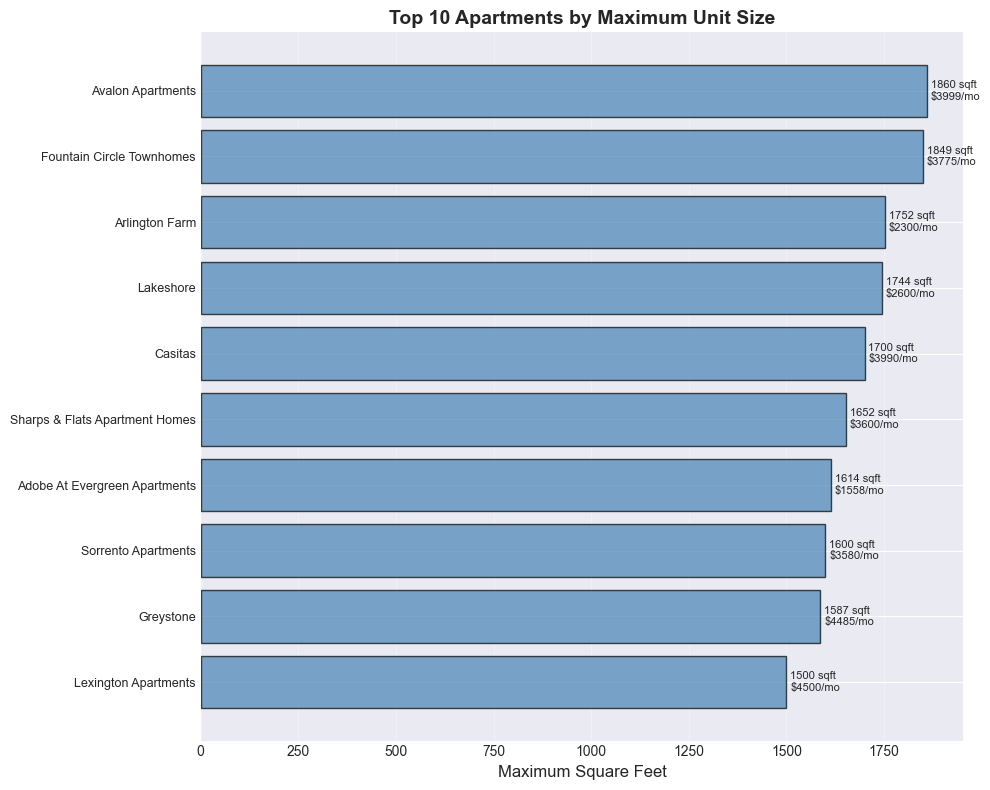

In [16]:
# Top 10 apartments by sqft_max (largest units available)
top_sqft = apartments.nlargest(10, 'sqft_max')[['name', 'sqft_max', 'rent_max', 'rent_per_sqft_avg']].copy()
top_sqft = top_sqft.sort_values('sqft_max', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_sqft))
bars = ax.barh(y_pos, top_sqft['sqft_max'], color='steelblue', alpha=0.7, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(top_sqft['name'], fontsize=9)
ax.set_xlabel('Maximum Square Feet', fontsize=12)
ax.set_title('Top 10 Apartments by Maximum Unit Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_sqft.iterrows()):
    ax.text(row['sqft_max'] + 10, i, f"{row['sqft_max']:.0f} sqft\n${row['rent_max']:.0f}/mo", 
            va='center', fontsize=8)

plt.tight_layout()
plt.show()

### Top 10 Best Value Apartments (Lowest Rent per Square Foot)

In [17]:
# Best value apartments (lowest rent per sqft)
best_value = apartments.nsmallest(10, 'rent_per_sqft_avg')[['name', 'rent_per_sqft_avg', 'avg_rent', 'sqft_min', 'sqft_max']].copy()
best_value = best_value.sort_values('rent_per_sqft_avg', ascending=True)

print("Top 10 Best Value Apartments (Lowest Rent per Square Foot):")
print("="*95)
for idx, row in best_value.iterrows():
    print(f"{row['name']:40s} | ${row['rent_per_sqft_avg']:.2f}/sqft | Avg Rent: ${row['avg_rent']:.0f} | Size: {row['sqft_min']:.0f}-{row['sqft_max']:.0f} sqft")


Top 10 Best Value Apartments (Lowest Rent per Square Foot):
Adobe At Evergreen Apartments            | $0.82/sqft | Avg Rent: $1088 | Size: 1024-1614 sqft
Axis at Davis                            | $0.92/sqft | Avg Rent: $1154 | Size: 1235-1268 sqft
Arlington Farm                           | $1.25/sqft | Avg Rent: $1475 | Size: 616-1752 sqft
The U Apartments                         | $1.31/sqft | Avg Rent: $1649 | Size: 1199-1328 sqft
DaVinci                                  | $1.56/sqft | Avg Rent: $1843 | Size: 1181-1181 sqft
Lakeshore                                | $1.61/sqft | Avg Rent: $2290 | Size: 1097-1744 sqft
Eastlake Apartments                      | $1.63/sqft | Avg Rent: $2097 | Size: 1285-1285 sqft
Sharps & Flats Apartment Homes           | $1.99/sqft | Avg Rent: $2508 | Size: 873-1652 sqft
Tanglewood@Davis                         | $2.00/sqft | Avg Rent: $2600 | Size: 1300-1300 sqft
Casitas                                  | $2.03/sqft | Avg Rent: $2235 | Size: 506-170

## 4. Location Analysis - Proximity to UC Davis

This section analyzes the distance and commute time from each apartment to UC Davis, a critical factor for students.


In [18]:
# UC Davis proximity statistics
print("UC Davis Proximity Statistics:")
print("="*40)
print(f"Mean distance to UCD: {apartments['ucd_distance_miles'].mean():.2f} miles")
print(f"Median distance to UCD: {apartments['ucd_distance_miles'].median():.2f} miles")
print(f"Min distance to UCD: {apartments['ucd_distance_miles'].min():.2f} miles")
print(f"Max distance to UCD: {apartments['ucd_distance_miles'].max():.2f} miles")

print(f"\nMean driving time to UCD: {apartments['ucd_time_min'].mean():.1f} minutes")
print(f"Median driving time to UCD: {apartments['ucd_time_min'].median():.1f} minutes")
print(f"Min driving time to UCD: {apartments['ucd_time_min'].min():.1f} minutes")
print(f"Max driving time to UCD: {apartments['ucd_time_min'].max():.1f} minutes")

# Count apartments by distance ranges
distance_ranges = [
    (apartments['ucd_distance_miles'] <= 1.0, "≤ 1 mile"),
    ((apartments['ucd_distance_miles'] > 1.0) & (apartments['ucd_distance_miles'] <= 2.0), "1-2 miles"),
    ((apartments['ucd_distance_miles'] > 2.0) & (apartments['ucd_distance_miles'] <= 3.0), "2-3 miles"),
    (apartments['ucd_distance_miles'] > 3.0, "> 3 miles")
]

print("\nApartments by Distance Range:")
for condition, label in distance_ranges:
    count = condition.sum()
    pct = (count / len(apartments)) * 100
    print(f"{label:15s}: {count:2d} apartments ({pct:5.1f}%)")

UC Davis Proximity Statistics:
Mean distance to UCD: 2.21 miles
Median distance to UCD: 2.01 miles
Min distance to UCD: 0.79 miles
Max distance to UCD: 4.39 miles

Mean driving time to UCD: 8.6 minutes
Median driving time to UCD: 8.8 minutes
Min driving time to UCD: 4.1 minutes
Max driving time to UCD: 12.6 minutes

Apartments by Distance Range:
≤ 1 mile       :  1 apartments (  2.1%)
1-2 miles      : 22 apartments ( 45.8%)
2-3 miles      : 19 apartments ( 39.6%)
> 3 miles      :  6 apartments ( 12.5%)


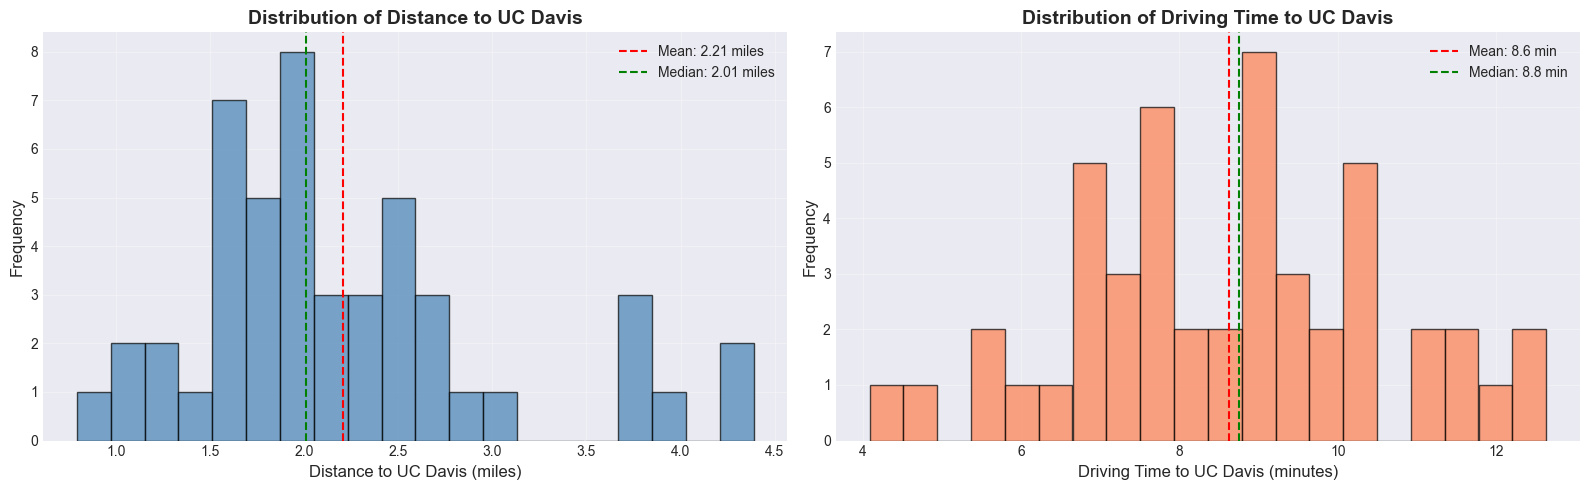

In [19]:
# Distance and time distribution histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of distance to UCD
axes[0].hist(apartments['ucd_distance_miles'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(apartments['ucd_distance_miles'].mean(), color='red', linestyle='--', 
                label=f'Mean: {apartments["ucd_distance_miles"].mean():.2f} miles')
axes[0].axvline(apartments['ucd_distance_miles'].median(), color='green', linestyle='--', 
                label=f'Median: {apartments["ucd_distance_miles"].median():.2f} miles')
axes[0].set_xlabel('Distance to UC Davis (miles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Distance to UC Davis', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of commute time to UCD
axes[1].hist(apartments['ucd_time_min'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(apartments['ucd_time_min'].mean(), color='red', linestyle='--', 
                label=f'Mean: {apartments["ucd_time_min"].mean():.1f} min')
axes[1].axvline(apartments['ucd_time_min'].median(), color='green', linestyle='--', 
                label=f'Median: {apartments["ucd_time_min"].median():.1f} min')
axes[1].set_xlabel('Driving Time to UC Davis (minutes)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Driving Time to UC Davis', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

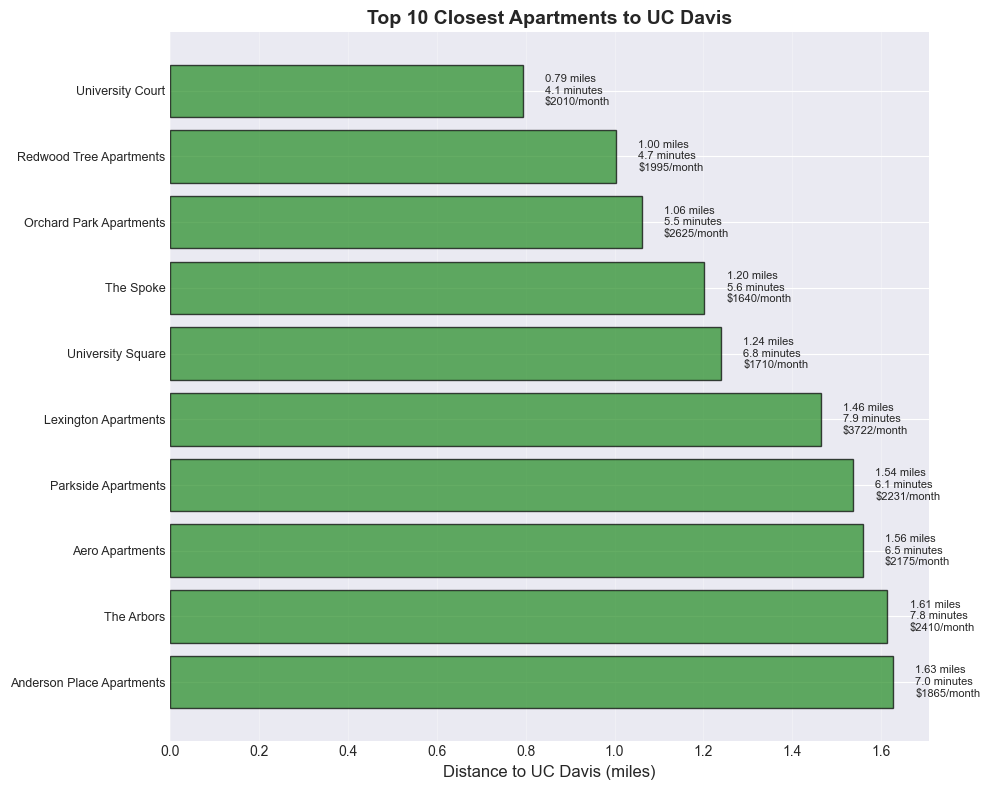

In [20]:
# Top 10 closest apartments to UCD
top_closest = apartments.nsmallest(10, 'ucd_distance_miles')[['name', 'ucd_distance_miles', 'ucd_time_min', 'avg_rent']].copy()
top_closest = top_closest.sort_values('ucd_distance_miles', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_closest))
bars = ax.barh(y_pos, top_closest['ucd_distance_miles'], color='forestgreen', alpha=0.7, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(top_closest['name'], fontsize=9)
ax.set_xlabel('Distance to UC Davis (miles)', fontsize=12)
ax.set_title('Top 10 Closest Apartments to UC Davis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_closest.iterrows()):
    ax.text(row['ucd_distance_miles'] + 0.05, i, 
            f"{row['ucd_distance_miles']:.2f} miles\n{row['ucd_time_min']:.1f} minutes\n${row['avg_rent']:.0f}/month", 
            va='center', fontsize=8)

plt.tight_layout()
plt.show()

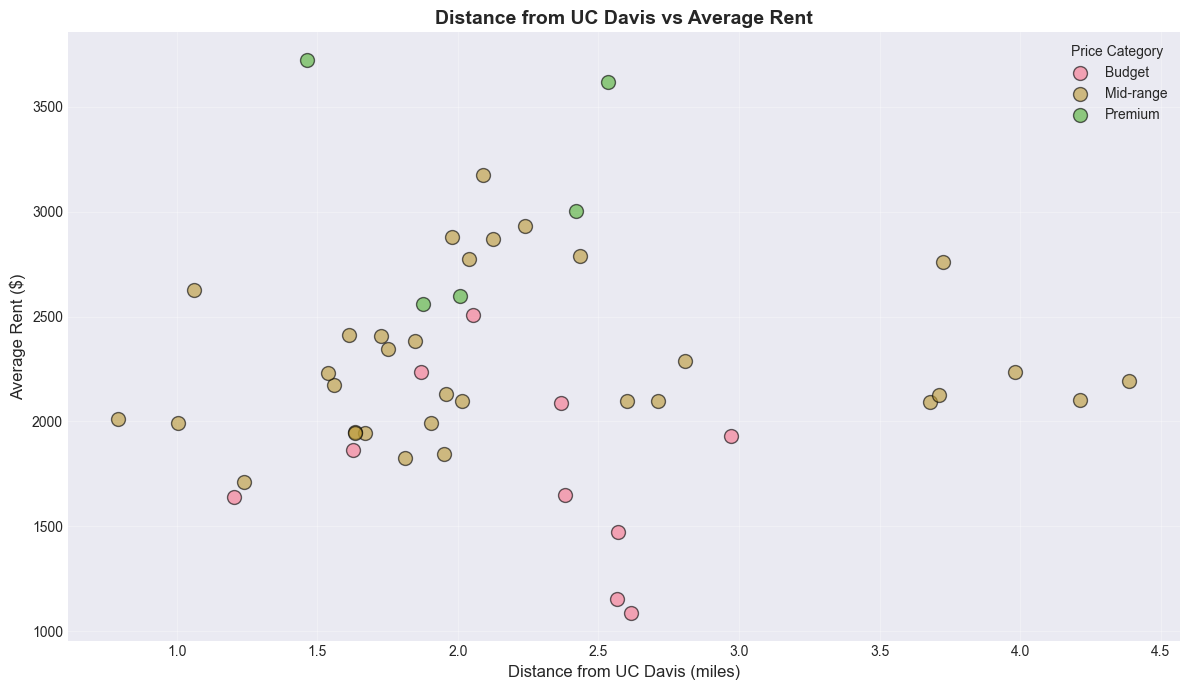

In [21]:
# Scatter plot: Distance from UC Davis vs Average Rent by Price Category
fig, ax = plt.subplots(figsize=(12, 7))

# Color by price category
for category in apartments['price_category'].dropna().unique():
    mask = apartments['price_category'] == category
    data = apartments[mask]
    ax.scatter(data['ucd_distance_miles'], data['avg_rent'], label=category, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax.set_xlabel('Distance from UC Davis (miles)', fontsize=12)
ax.set_ylabel('Average Rent ($)', fontsize=12)
ax.set_title('Distance from UC Davis vs Average Rent', fontsize=14, fontweight='bold')
ax.legend(title='Price Category', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()